In [1]:
!which python

/scratch/smp/uqsmac12/.conda/env/lit_torch_gp/bin/python


WHERE IS THE DATA: 'Q2051'

In [2]:
import os
from anndata import read_h5ad
import numpy as np

In [3]:
import pandas as pd

In [15]:
import os
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional as F

from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
# from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [5]:
# update the location where models will be saved to
if torch.hub.get_dir() == '/clusterdata/uqsmac12/.cache/torch/hub':
    torch.hub.set_dir('/scratch/smp/uqsmac12/.cache/torch/hub')

In [6]:
import matplotlib.pyplot as plt

In [ ]:
# setup new conda environment

# load data

# implement somthing similar to STimage1

# test likelihood assumption with log [CPT] data transform
# test likelihood assumption without transform

# load data

In [7]:
torch.cuda.is_available()

True

In [8]:
DIR_DATA = '/scratch/smp/uqsmac12/stimage2_data'
DIR_CHECKPOINTS = os.path.join(DIR_DATA, 'checkpoints')
DIR_WANDB = DIR_DATA

In [9]:
DIR_TILES = '/scratch/smp/uqsmac12/dataset_breast_cancer_9visium'
DIR_ANNDATA_PROCESSED = '/scratch/smp/uqsmac12/dataset_breast_cancer_9visium'
file_processed_alex_data = 'all_adata.h5ad'
# DIR_PROCESSED_DATA = '/afm03/Q2/Q2051/STimage_project/STimage_dataset/PROCESSED/dataset_breast_cancer_9visium'

In [10]:
adata_all = read_h5ad(os.path.join(DIR_ANNDATA_PROCESSED, file_processed_alex_data))

In [11]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        DIR_TILES))

In [12]:
assert 'uqsmac12' in adata_all.obs['tile_path'][0]

In [13]:
gene_list = ["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

The gene expressions, $X$, are log transformed, hence $\exp(X)\sim\text{NegativeBinomial}(.)$

Get counts

In [14]:
X_counts = np.exp(adata_all.to_df().values)

In [16]:
import os
import pandas as pd
from torchvision.io import read_image

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [55]:
class STimageDataset(Dataset):
#     def __init__(self, adata, dim=(299, 299), n_channels=3, genes=None, transform=None, target_transform=None):
    def __init__(self, adata, genes=None, transform=None, target_transform=None):
        self.adata = adata
#         self.dim = dim
#         self.n_channels = n_channels
        self.genes = genes
        self.num_genes = len(genes)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        
        return int(self.adata.n_obs)
    
    def __getitem__(self, idx):
        idx_name = adata_all.obs_names[idx]
        X_img = self.load_img(idx_name)
        y = self.get_expression(idx_name)
        
        return X_img, y
    
    def load_img(self, key):
        """load an image"""
        img_path = self.adata.obs.loc[key, 'tile_path']
        X_img = read_image(img_path)
#         # if shape illegal cast to proper shape
#         if X_img.shape != (self.n_channels, dim[0], dim[1]):
#             assert False, 'not tested'
#             X_img = transforms.Resize(self.dim)(X_img)
            
        if self.transform:
#             X_img = seq_aug(image=X_img)
            X_img = self.transform(X_img)
        
        return X_img
    
    def get_expression(self, key):
        y = torch.Tensor(adata_all[idx_name, gene_list].to_df().values)
        
        if self.target_transform:
            y = self.target_transform(y)
        
        return y

In [56]:
dataset = STimageDataset(adata_all, genes=gene_list)

In [63]:
x,y = dataset.__getitem__(3)

In [64]:
x.shape

torch.Size([3, 299, 299])

In [65]:
y.shape

torch.Size([1, 14])

In [66]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [68]:
x, y = next(iter(dataloader))

In [81]:
images = datasets.ImageFolder('')

tensor(0, dtype=torch.uint8)

In [ ]:
self.adata.obs_names[index]

In [ ]:
class DataGenerator(torch.utils.data.Dataset):
    """
    data generator for multiple branches gene prediction model
    """

    def __init__(self, adata, dim=(299, 299), n_channels=3, genes=None: list, transform=None, tile_path="tile_path"):
        'Initialization'
        self.dim = dim
        self.adata = adata
        self.n_channels = n_channels
        self.genes = genes
        self.num_genes = len(genes)
        self.aug = aug
        self.tile_path = tile_path
        self.indexes = np.arange(self.adata.n_obs)
        
    def __len__(self):
        'Denotes the number of samples'
        return int(self.adata.n_obs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Find obs name
        obs_temp = self.adata.obs_names[index]

        # Generate data
        X_img, y = self._load_data(obs_temp)

        return torch.Tensor(X_img), torch.Tensor(y)

    def _load_data(self, obs):
        img_path = self.adata.obs.loc[obs, 'tile_path']
        X_img = Image.open(img_path).convert('RGB')
        X_img = transforms.Resize(self.dim)(X_img)
        X_img = np.array(X_img).astype('uint8')
        #         X_img = np.expand_dims(X_img, axis=0)
        #         n_rotate = np.random.randint(0, 4)
        #         X_img = np.rot90(X_img, k=n_rotate, axes=(1, 2))
        if self.aug:
            X_img = seq_aug(image=X_img)
        y = self._load_label(obs)
        return X_img, y

    def _load_label(self, obs):
        batch_adata = self.adata[obs, self.genes].copy()
        
        return tuple([batch_adata.to_df()[i].values for i in self.genes])

    def get_classes(self):
        return self.adata.to_df().loc[:, self.genes]

In [16]:
library_size = X_counts.sum(axis=1).reshape(-1,1)

In [17]:
X_cpm = X_counts * 1e6 / library_size

In [18]:
X_cpm[:10,3]

array([ 56.564285,  55.577168,  49.622868,  50.4923  , 103.54111 ,
        52.012897, 106.89471 ,  51.642223,  54.671696,  53.2198  ],
      dtype=float32)

In [19]:
cols = adata_all.to_df().columns

In [20]:
df_X_cpm = pd.DataFrame(X_cpm, columns=cols)

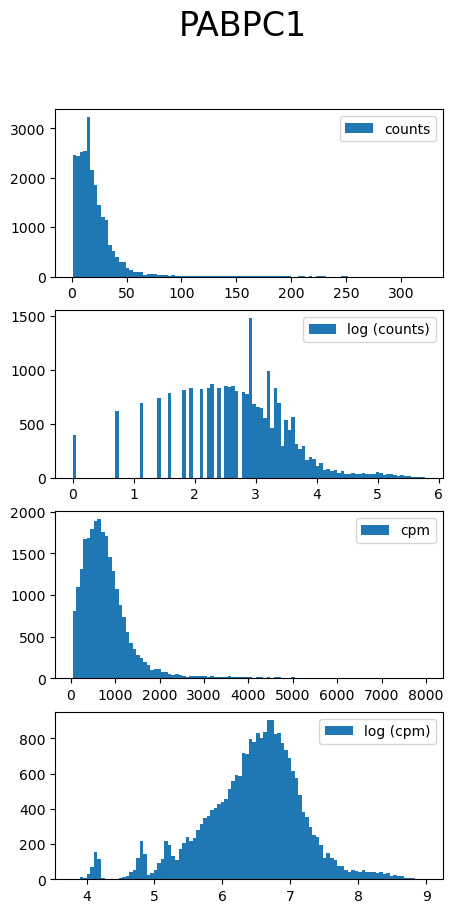

In [23]:
gene = 'PABPC1'

x_cpm = df_X_cpm[gene].values.reshape(-1)

x_counts = np.exp(adata_all[:,gene].to_df().values.reshape(-1)).round(0).astype(int)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5,10))
ax[0].hist(x_counts, bins=100, label='counts')
ax[0].legend()
ax[1].hist(np.log(x_counts), bins=100, label='log (counts)')
ax[1].legend()
ax[2].hist(x_cpm, bins=100, label='cpm')
ax[2].legend()
ax[3].hist(np.log(x_cpm), bins=100, label='log (cpm)')
ax[3].legend()
fig.suptitle(gene, size=24)
fig.show()

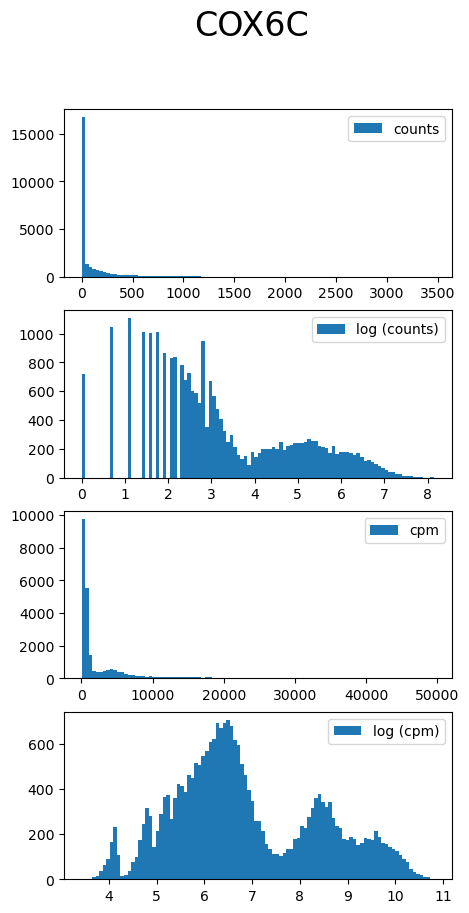

In [24]:
gene = 'COX6C'

x_cpm = df_X_cpm[gene].values.reshape(-1)

x_counts = np.exp(adata_all[:,gene].to_df().values.reshape(-1)).round(0).astype(int)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5,10))
ax[0].hist(x_counts, bins=100, label='counts')
ax[0].legend()
ax[1].hist(np.log(x_counts), bins=100, label='log (counts)')
ax[1].legend()
ax[2].hist(x_cpm, bins=100, label='cpm')
ax[2].legend()
ax[3].hist(np.log(x_cpm), bins=100, label='log (cpm)')
ax[3].legend()
fig.suptitle(gene, size=24)
fig.show()

log (cpm) appears best... why it doesn't get used is a bit of a mystery.